<a href="https://colab.research.google.com/github/AlfonsoVasquezC/ComputervisionMNA/blob/main/Equipo01_Semana10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

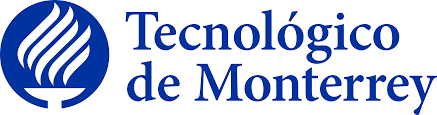

**Maestría en Inteligencia Artificial Aplicada / MNA / Tecnológico de Monterrey**

**Escuela de Ingeniería y Ciencias**

**Actividad en Equipos - Semanas 10: Transformer GPT & Web-Scraping**

**ITESM Campus Guadalajara Dr. Luis Eduardo Falcón Morales**

Nombre(s): RODRIGO RODRIGUEZ RODRIGUEZ, RIGOBERTO VEGA ESCUDERO, ALEXIS HERNANDEZ MARTINEZ, JUAN ALFONSO VASQUEZ CHAPOI, GERARDO AARON CASTAÑEDA JARAMILLO

Matrícula(s): A01183284 , A01793132 , A01016308 , A00820656 , A01137646


## **Introducción**

En la actividad de esta semana trabajarás en equipos mediante el uso del Transformer GPT y comentarios de usuarios obtenidos mediante WebScraping en Tripadvisor.


A través de Tripadvisor ( https://www.tripadvisor.es/ ) en español obtendremos los comentarios de usuarios sobre su experiencia en un hotel en particular. En esta plataforma se evalúa la experiencia mediante puntos de 1 a 5, que corresponden de manera ascendente a “Pésimo”, “Malo”, “Normal”, “Muy bueno” y “Excelente”.


Una de las formas en que se han venido utilizando los generadores de texto como el GPT, es para generar datos sintéticos de texto que no tengan problemas de privacidad. En particular en esta actividad los usaremos para generar datos sintéticos sobre comentarios positivos y negativos de usuarios y posteriormente los usaremos para ver si ayudan a mejor el desempeño de un modelo de clasificación.


De la siguiente liga de Tripadvisor selecciona un hotel en la zona de la ciudad de Monterrey, México, que consideres adecuado para extraer los comentarios de español y evaluaciones de usuarios:
https://www.tripadvisor.es/Hotels-g150782-Monterrey_Northern_Mexico-Hotels.html


En particular trata de seleccionar algún hotel cuyas calificaciones consideres desbalanceadas, al verlo como un problema binario: Positivo (4, 5) y Negativo (1, 2 3).

## **Pregunta 1**

Mediante web scraping realiza una extracción de los comentarios y calificaciones a dicho hotel. Recuerda que Tripadvisor representa las calificaciones mediante círculos verdes. Los comentarios deben ser de usuarios que los redactaron en idioma en español. Indica la cantidad de comentarios y sus calificaciones que extrajiste.

En esta sección, nos basamos en el código del Dr Falcón en los ejercicios complementarios de la semana 10, seleccionamos el hotel Live Aqua de Monterrey y con base al mismo generamos la extracción de información.

In [1]:
import requests
from bs4 import BeautifulSoup as soup
from random import randint
from time import sleep
import re
import pandas as pd

In [2]:
#!pip install SentencePiece
#!pip install datasets transformers[sentencepiece]

Seleccionamos el hotel y comentarios en español:

In [3]:
# Selecciones este hotel en particular como ejercicio de prueba:

url = 'https://www.tripadvisor.es/Hotel_Review-g1154799-d9092664-Reviews-Live_Aqua_Urban_Resort_Monterrey-San_Pedro_Garza_Garcia_Monterrey_Northern_Mexico.html#REVIEWS'

html = requests.get(url,
                    headers={"User-Agent": "Mozilla/5.0 (X11; CrOS x86_64 12871.102.0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.4044.141 Safari/537.36"}
                    )

print(html.status_code)     # la salida "200" solo es el status de que hubo respuesta con la página indicada.

200


Primero recopilemos todos los links de las opiniones:

In [4]:
links = []

max_or_num = 225  # El valor de max_or_num es el mayor múltiplo de 5 menor al total de reseñas en español.
                 # Como en este caso, al momento de hacer el web-scraping se tenían 53 comentarios en español,
                 # el valor de max_or_num sería 50.


reviews_x_pages = 5    # tienes que verificar si van de 10 en 10, o 5 en 5 las reseñas en cada página, porque cada caso es diferente....

for k in range(0, max_or_num, reviews_x_pages):
  a = url
  if k == 0:
    ss = '{}'     # Para la primera página es el -or con valor vacío.
  else:
    ss = str(k)  # convertimos a string el valor numérico.
  a = a[:(a.find('Reviews')+7)] + '-or' + ss + a[(a.find('Reviews')+7):]  # Los índices de "Reviews" van de 0 a 6, ya que tiene 7 letras.
  links.append(a)


links

['https://www.tripadvisor.es/Hotel_Review-g1154799-d9092664-Reviews-or{}-Live_Aqua_Urban_Resort_Monterrey-San_Pedro_Garza_Garcia_Monterrey_Northern_Mexico.html#REVIEWS',
 'https://www.tripadvisor.es/Hotel_Review-g1154799-d9092664-Reviews-or5-Live_Aqua_Urban_Resort_Monterrey-San_Pedro_Garza_Garcia_Monterrey_Northern_Mexico.html#REVIEWS',
 'https://www.tripadvisor.es/Hotel_Review-g1154799-d9092664-Reviews-or10-Live_Aqua_Urban_Resort_Monterrey-San_Pedro_Garza_Garcia_Monterrey_Northern_Mexico.html#REVIEWS',
 'https://www.tripadvisor.es/Hotel_Review-g1154799-d9092664-Reviews-or15-Live_Aqua_Urban_Resort_Monterrey-San_Pedro_Garza_Garcia_Monterrey_Northern_Mexico.html#REVIEWS',
 'https://www.tripadvisor.es/Hotel_Review-g1154799-d9092664-Reviews-or20-Live_Aqua_Urban_Resort_Monterrey-San_Pedro_Garza_Garcia_Monterrey_Northern_Mexico.html#REVIEWS',
 'https://www.tripadvisor.es/Hotel_Review-g1154799-d9092664-Reviews-or25-Live_Aqua_Urban_Resort_Monterrey-San_Pedro_Garza_Garcia_Monterrey_Northern_Mex

Ya tenemos los links de cada página de los comentarios, ahora procedemos a extraer los reviews que tiene cada página:

In [5]:
reviews = []
stars =[]

numpages = int( max_or_num / reviews_x_pages )                    # puede tardar varios minutos si son muchos registros a extraer.

for link in links[0:numpages]:
  print(link)

  headers = {'User-Agent':'Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.97 Safari/537.36' }
  html2 = requests.get(link, headers=headers)
  #print(html2.status_code)

  sleep(randint(1,5))   # se incluyen intervalos de sleep para que no se estén haciendo llamadas de manera continua a la página
                        # y que al detectar esta actividad continua, se pueda detectar como una actividad sospechosa por el servidor
                        # y nos pueda bloquear de manera automática por ello.
  bsobj2 = soup(html2.content,'lxml')   # objeto de la librería BeautifulSoup para llevar a cabo nuestra tarea.

  # Extraemos los comentarios de cualquiera de las siguientes dos formas:
  # Incluimos algunos Print solo para visualizar la manera en que se lleva a cabo el proceso:

  #for review in bsobj2.findAll('span', class_='QewHA'):       # Forma 1:  Estamos en "span", Observa el guión-bajo al final de "class_"
  for review in bsobj2.findAll('span', {'class' : 'QewHA'}):   # Forma 2
      print(review.text)
      reviews.append(review.text.strip())

  sleep(randint(1,5))
  bsobj3 = soup(html2.content,'lxml')

  # Extraigamos también las calificaciones (estrellas):
  # Observa que las calificaciones están en unidades de 10, 20, 30, 40, 50.
  # En particular en este caso haremos la extracción de todo el string donde se encuentra la
  # calificación al hotel por parte del usuario y a partir de ahí mediante regex puedes
  # fácilmente realizar la extracción de la calificación:
  for cal in bsobj3.findAll('div', {'class' : 'Hlmiy'}):
    print(cal)
    #  Aquí puedes incluir tu regex para extraer solo la calificación numérica.
    stars.append(cal)

https://www.tripadvisor.es/Hotel_Review-g1154799-d9092664-Reviews-or{}-Live_Aqua_Urban_Resort_Monterrey-San_Pedro_Garza_Garcia_Monterrey_Northern_Mexico.html#REVIEWS
Primeramente, les puedo compartir que mi esposa y yo consideramos Live Aqua como nuestra casa en San Pedro.  La ubicación, las instalaciones y la amabilidad del personal hacen que nuestra estancia SIEMPRE sea placentera. Lo que encontramos mas impresionante, es la regadera y como cuenta con su tina aislada con vista al exterior. La comida del restaurant es fenomenal.  Recomiendo los chilaquiles negros.  Simplemente los mejores!
Para disfrutar de la ciudad de Monterrey, con excelente ubicación, modernas instalaciones y el olor característico de los Aqua, delicioso. Sin embargo, me disgustó que no cuenta con alberca para llegar y refrescarse después de tanto calor. 
Siempre procuro quedarme en este hotel ya sea el Grans Fiesta o el Aqua, en verdad muy recomendable, servicio de primera, cuartos muy cómodos y bien decorados , 

Cantidades:

In [6]:
print('Cantidad de comentarios extraídos:', len(reviews))
print('Cantidad de claificaciones:', len(stars))

Cantidad de comentarios extraídos: 225
Cantidad de claificaciones: 225


Ratings:

In [7]:
from bs4 import BeautifulSoup

# Assuming the variable stars contains the list of HTML elements

ratings = []
for star in stars:
    soup = BeautifulSoup(str(star), 'html.parser')
    rating_class = soup.find('span', class_='ui_bubble_rating')['class'][-1]
    rating = int(rating_class.split('_')[-1]) / 10
    ratings.append(rating)


ratings = [int(rating) for rating in ratings]

print(ratings)

[5, 5, 5, 5, 3, 5, 5, 5, 1, 1, 5, 5, 5, 3, 4, 5, 5, 5, 2, 5, 5, 5, 1, 2, 2, 5, 1, 3, 5, 2, 5, 1, 1, 5, 5, 3, 5, 5, 5, 2, 5, 1, 4, 5, 5, 5, 5, 4, 5, 1, 5, 5, 5, 5, 2, 5, 1, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 1, 5, 5, 4, 5, 4, 4, 5, 5, 5, 5, 2, 5, 2, 5, 4, 5, 5, 5, 5, 1, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 2, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 5, 5, 5, 5, 4, 5, 5, 4, 5, 5, 5, 5, 5, 4, 4, 4, 4, 5, 5, 4, 5, 5, 5, 5, 5, 5, 4, 2, 5, 5, 3, 4, 5, 5, 5, 3, 4, 5, 5, 5, 5, 5, 5, 5, 1, 5, 1, 5, 4, 5, 5, 1, 5, 2, 5, 5, 5, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]


## **Pregunta 2**

Para considerarlo como un problema binario, convierte las calificaciones a valores de 0 (comentario negativo) y 1 (comentario positivo).

### **Inciso A**

En particular indica cómo considerarás las calificaciones entre 3 y 4, como 3.5, por ejemplo. Justifica la decisión tomada.

Comenzamos observando su distribución:

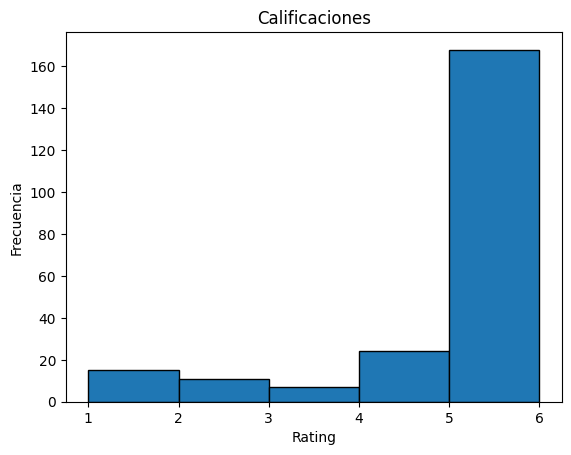

Rating 5: 168 occurrences
Rating 3: 7 occurrences
Rating 1: 15 occurrences
Rating 4: 24 occurrences
Rating 2: 11 occurrences


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import matplotlib.pyplot as plt

# Convert the int values to strings
ratings = [str(rating) for rating in ratings]

# Extract the rating values from the 'ratings' list
rating_values = [int(re.search(r'\d+', rating).group()) for rating in ratings]

# Define the bin edges
bin_edges = [1, 2, 3, 4, 5, 6]

# Plot the histogram
plt.hist(rating_values, bins=bin_edges, edgecolor='black')

# Customize the plot
plt.title('Calificaciones')
plt.xlabel('Rating')
plt.ylabel('Frecuencia')

# Show the plot
plt.show()

# Count the frequency of each rating value
rating_frequency = Counter(rating_values)

# Display the frequency of each rating value
for rating, frequency in rating_frequency.items():
    print(f"Rating {rating}: {frequency} occurrences")

**R:** En este caso todas las calificaciones son enteras, por lo que en realidad tenemos solamente un rango de números enteros (1,2,3,4,5). Revisando abajo la gráfica de frecuencia, podemos ver que el dataset está desbalanceado, muy cargado hacia los comentarios con calificación 5, seguidos por 4. Derivado de lo mismo, se decide que los comentarios negativos serán del rango 1-3 mientras que los datos positivos serán del rango 4-5.

### **Inciso B**

Indica la proporción de comentarios positivos y negativos que tienes ahora.



En esta parte se crea una nueva lista llamada valoración, con la cual marcamos los registros ya sea con 0 si su calificación es entre 1-3, o los marcamos con 1 si su calificación va entre 4-5:

In [9]:
# Create a new variable "valoracion" based on "ratings"
valoracion = []

for rating in ratings:
    if rating == '4' or rating == '5':
        valoracion.append(1)
    elif rating == '1' or rating == '2' or rating == '3':
        valoracion.append(0)
    else:
        valoracion.append(None)

In [10]:
print(valoracion)

[1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


Finalmente hacemos una gráfica de frecuencias para ver cuántos comentarios negativos y positivos tenemos.

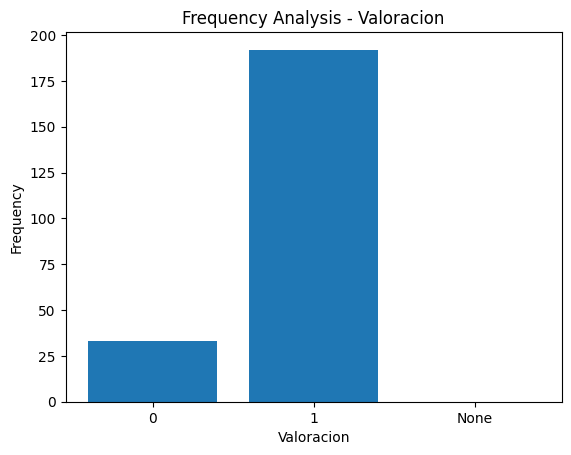

Valoracion 0: 33 occurrences
Valoracion 1: 192 occurrences
Valoracion None: 0 occurrences


In [11]:
# Frequency analysis for "valoracion"
valoracion_counts = {str(0): 0, str(1): 0, 'None': 0}

# Count the occurrences of each value in "valoracion"
for value in valoracion:
    if value is None:
        valoracion_counts['None'] += 1
    else:
        valoracion_counts[str(value)] += 1

# Plotting the graph
plt.bar(valoracion_counts.keys(), valoracion_counts.values())
plt.xlabel('Valoracion')
plt.ylabel('Frequency')
plt.title('Frequency Analysis - Valoracion')
plt.show()

# Frequency in text
for value, count in valoracion_counts.items():
    print(f"Valoracion {value}: {count} occurrences")

**R:** 33 Negativos - 192 Positivos

## **Pregunta 3**

Selecciona y aplica un modelo Transformer generador de texto en español de la plataforma de HuggingFace para “balancear” los porcentajes de comentarios positivos y negativos.

Indica la cantidad de datos sintéticos que vas a generar, en particular contesta las siguientes preguntas:





**a.** ¿Vas a generar solo datos de la clase negativa minoritaria o de ambas clases? ¿Por qué?

**R:** Se generan solamente calificaciones sintéticas negativas para balancear lo más posible la cantidad de comentarios negativos con positivos.


**b.** ¿Qué porcentaje de nuevo balanceo de clases vas a generar? ¿Por qué? NOTA: Recuerda que no siempre es lo mejor balancearlos al 50% cada clase, porque si el conjunto original está demasiado desbalanceado y los datos sintéticos generados son de muy buena calidad, los resultados obtenidos al final podrían ser bastante desastrosos.

**R:** El porcentaje de reequilibrio de clases nuevas a generar debe elegirse con cuidado, teniendo en cuenta la distribución de clases inicial y la calidad de los datos sintéticos. Puede que no siempre sea ideal equilibrar las clases exactamente en un 50 % cada una, especialmente si el conjunto de datos original está muy desequilibrado como es en este caso.. Un enfoque razonable sería generar suficientes datos sintéticos para acercar a la clase minoritaria a la clase mayoritaria sin igualarlas por completo, por lo que proponemos una distribución 60 positivos-40 negativos.


En este punto crearemos un dataframe en donde podamos tener juntas las tres columnas: el comentario, el rating original de 1-5 y su valoración entre 0-1.

In [12]:
# Create a dictionary with the data
data = {
    'ratings': ratings,
    'valoracion': valoracion,
    'reviews': reviews
}

# Create the DataFrame
df = pd.DataFrame(data)

df['ratings'] = pd.Categorical(df['ratings'])
df['valoracion'] = pd.Categorical(df['valoracion'])

# Display the DataFrame
print(df)

    ratings valoracion                                            reviews
0         5          1  Primeramente, les puedo compartir que mi espos...
1         5          1  Para disfrutar de la ciudad de Monterrey, con ...
2         5          1  Siempre procuro quedarme en este hotel ya sea ...
3         5          1  Fue una experiencia de lujo, el staff siempre ...
4         3          0  La calidad de los servicios, la variedad del m...
..      ...        ...                                                ...
220       5          1  Pasé el fin de semana en el hotel y quede fasc...
221       5          1  Excelente hotel , me atrevería a decir que son...
222       5          1  Un hotel muy bonito, lujoso, el personal es su...
223       5          1  Después de pasar 2 noches en el hotel quede im...
224       5          1  Aunque muy nuevo, y el equipo aun se está capa...

[225 rows x 3 columns]


En esta parte comenzamos a separar la información en dos listas. La primera de ellas contendrá todos los comentarios cuya valoración sea 1. La segunda lista incluirá todos los comentarios cuya valoración sea 0.

In [13]:
# Create an empty list for positive comments
positive_comments = []

# Create an empty list for negative comments
negative_comments = []

# Iterate over each row in the DataFrame
for index, row in df.iterrows():
    # Check if valoracion is equal to 1
    if row['valoracion'] == 1:
        positive_comments.append(row['reviews'])
    # Check if valoracion is equal to 0
    elif row['valoracion'] == 0:
        negative_comments.append(row['reviews'])

# Confirm the lenght of each list.
print(len(positive_comments))
print(len(negative_comments))

192
33


Ya que tenemos los comentarios separados en lista, creamos un dataframe para cada uno de ellos, agregando nuevamente la columna de ratings. Para la lista de positivas los dejamos con rating valor a 1 y para la lista negativa la dejamos con rating valor a 0. Finalmente concatenamos ambos dataframe y creamos uno que vamos a llamar unbalanced_dataset, que trae solamente los comentarios originales de TripAdvisor.

In [14]:
# Create a DataFrame
df_positive_unbalanced = pd.DataFrame({'comments': positive_comments, 'ratings': 1})
df_negative_unbalanced = pd.DataFrame({'comments': negative_comments, 'ratings': 0})

unbalanced_dataset = pd.concat([df_positive_unbalanced, df_negative_unbalanced], ignore_index=True)

In [17]:
#!pip install torch
#!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 71.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 89.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 65.1 MB/s eta 0:00:00


In [18]:
import torch

from transformers import T5ForConditionalGeneration, T5Tokenizer
torch.cuda.is_available()

True

A continuación escogemos el porcentaje de distribución de clases, en este caso, 60-40.

In [19]:
positive_count = len(positive_comments)
negative_count = len(negative_comments)
desired_ratio = 0.6  # Desired ratio: 60% positive, 40% negative
synthetic_samples_needed = int((positive_count/desired_ratio)-(positive_count + negative_count))
print(synthetic_samples_needed)

95


Donde observamos que ocupamos generar 95 datos sintéticos para la clase negativa.

In [20]:
#!pip install xformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.1/109.1 MB 7.6 MB/s eta 0:00:00


Observamos 5 textos generados de ejemplo:

In [21]:
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline, set_seed
tokenizer = AutoTokenizer.from_pretrained("PlanTL-GOB-ES/gpt2-base-bne")
model = AutoModelForCausalLM.from_pretrained("PlanTL-GOB-ES/gpt2-base-bne")
generator = pipeline('text-generation', tokenizer=tokenizer, model=model)
set_seed(42)
generator("Este hotel no me gusta por", num_return_sequences=5)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


[{'generated_text': 'Este hotel no me gusta por la ubicación, pero si por su restaurante. '},
 {'generated_text': 'Este hotel no me gusta por el aspecto urbano por lo que no es de lo recomendable y los precios son muy buenos. '},
 {'generated_text': 'Este hotel no me gusta por la cantidad excesiva de personas que vienen, por lo menos por mi madre pero no por eso. '},
 {'generated_text': 'Este hotel no me gusta por el ambiente de una sola planta y de la cocina y de las habitaciones. '},
 {'generated_text': 'Este hotel no me gusta por la ubicación y por estar aislado. '}]

Generamos nuestros 95 datos sintéticos para la clase negativa:

In [22]:
synthetic_negative_comments = []
for _ in range(synthetic_samples_needed):
    # Generate synthetic negative comment using the text generator model
    outputs = generator("Califique mal a este hotel porque", num_return_sequences=1)

    # Add synthetic comment to the list of negative comments
    negative_comments.append(outputs[0]["generated_text"])
    synthetic_negative_comments.append(outputs[0]["generated_text"])

Confirmamos los ratios deseados de cada clase:

In [23]:
print('Positive Ratio:', len(positive_comments)/(len(positive_comments)+len(negative_comments)))
print('Negative Ratio:', len(negative_comments)/(len(positive_comments)+len(negative_comments)))

Positive Ratio: 0.6
Negative Ratio: 0.4


En esta parte realizamos nuevamente un dataframe para cada lista. En el caso de los positivos, la lista es la misma que la desbalanceada. En este caso, la lista negativa ya trae los comentarios sintéticos. Se crea un dataframe con la columna del comentario y la columna del rating respectivo.

In [24]:
balanced_positive_comments = positive_comments
balanced_negative_comments = negative_comments

# Create a DataFrame
df_positive = pd.DataFrame({'comments': balanced_positive_comments, 'ratings': 1})

# Create a DataFrame
df_negative = pd.DataFrame({'comments': balanced_negative_comments, 'ratings': 0})

# Print the DataFrame
print(df_positive.head())
print(df_negative.head())

                                            comments  ratings
0  Primeramente, les puedo compartir que mi espos...        1
1  Para disfrutar de la ciudad de Monterrey, con ...        1
2  Siempre procuro quedarme en este hotel ya sea ...        1
3  Fue una experiencia de lujo, el staff siempre ...        1
4  muy buen servicio. continuen así. es garantia ...        1
                                            comments  ratings
0  La calidad de los servicios, la variedad del m...        0
1  El servicio no fue malo, sin embargo las habit...        0
2  Mala experiencia, no es nada barato, de echo e...        0
3  El hotel destaca por su diseño y comodidad. Es...        0
4  De todos los hoteles de la misma gama q he vis...        0


Finalmente revisamos brevemente ambos datasets, el balanceado y el desbalanceado.

In [25]:
balanced_dataset = pd.concat([df_positive, df_negative], ignore_index=True)

print('Dataset balanceado',len(balanced_dataset))
print('Dataset no balanceado', len(unbalanced_dataset))

Dataset balanceado 320
Dataset no balanceado 225


## **Pregunta 4**

Realiza una partición de los datos en entrenamiento, validación y prueba con los porcentajes que consideres adecuados.

En esta parte hacemos la partición para el dataset balanceado.

In [26]:
from sklearn.model_selection import train_test_split

# Split the balanced dataset into training, validation, and test sets
train_ratio1 = 0.7  # Percentage of data for training
val_ratio1 = 0.15  # Percentage of data for validation
test_ratio1 = 0.15  # Percentage of data for testing

# Split the data
train_data1, remaining_data1 = train_test_split(balanced_dataset, test_size=(1 - train_ratio1), random_state=42)
val_data1, test_data1 = train_test_split(remaining_data1, test_size=test_ratio1/(test_ratio1 + val_ratio1), random_state=42)

# Print the sizes of the partitions
print("Training set size:", len(train_data1))
print("Validation set size:", len(val_data1))
print("Test set size:", len(test_data1))


Training set size: 223
Validation set size: 48
Test set size: 49


En esta parte hacemos la partición para el dataset desbalanceado.

In [27]:
# Split the balanced dataset into training, validation, and test sets
train_ratio2 = 0.7  # Percentage of data for training
val_ratio2 = 0.15  # Percentage of data for validation
test_ratio2 = 0.15  # Percentage of data for testing

# Split the data
train_data2, test_data2 = train_test_split(unbalanced_dataset, test_size=test_ratio2, random_state=42)
#val_data2, test_data2 = train_test_split(remaining_data2, test_size=test_ratio2/(test_ratio2 + val_ratio2), random_state=42)

# Print the sizes of the partitions
print("Training set size:", len(train_data2))
print("Test set size:", len(test_data2))

Training set size: 191
Test set size: 34


## **Pregunta 5**

Mediante un Transformer que consideres adecuado para idioma español de la plataforma HuggingFace, aplica un modelo de clasificación binaria (análisis de sentimiento) para los datos originales, es decir, sin incluir los comentarios sintéticos. ¿Qué desempeño obtienes? NOTA: Justifica el procedimiento utilizado. Es decir, podrías utilizar un modelo Transformer de manera directa (out-of-box), en cuyo caso la evaluación la haces de manera directa sobre el conjunto entrenamiento+validación. O bien, usar un modelo Transformer con fine-tuning en cuyo caso entrenas con el conjunto de entrenamiento y validas con el de prueba.
En cuanto al Transformer a utilizar, está “PlanTL-GOB-ES/gpt2-large-bne” de la versión de MarIA, pero puedes utilizar algún otro si lo consideras adecuado.

In [ ]:
#!pip install xformers

Utilizamos el modelo 'distilbert-base-multilingual-cased':

In [28]:
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
import tensorflow as tf

# Load the tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-multilingual-cased')

texts = train_data2['comments'].tolist()  # Convert to list of strings

# Encode the text data
encoded_inputs = tokenizer(texts, padding=True, truncation=True, return_tensors='tf')

# Make predictions
outputs = model(encoded_inputs.input_ids, attention_mask=encoded_inputs.attention_mask)
predicted_labels = tf.argmax(outputs.logits, axis=1).numpy()

# Map predicted labels back to sentiment classes (positive/negative)
sentiment_labels = ['0', '1']
predicted_sentiments = [sentiment_labels[label] for label in predicted_labels]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

En este parte del código transformamos en entero las predicciones y de esta forma comparamos los resultados en términos de accuracy contra los ratings actuales:

In [29]:
predicted_sentiments2 = [int(label) for label in predicted_sentiments]
actual_labels = train_data2['ratings'].tolist()

# Compare predicted labels with actual labels
correct_predictions = sum(1 for pred, actual in zip(predicted_sentiments2, actual_labels) if pred == actual)
total_predictions = len(actual_labels)

accuracy = correct_predictions / total_predictions
print("Accuracy: {:.2%}".format(accuracy))

Accuracy: 83.25%


Graficamos su distribución de clases para sus predicciones:

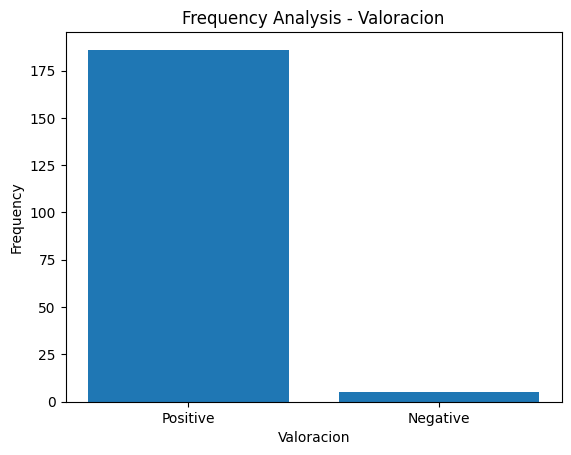

Valoracion Positive: 186 occurrences
Valoracion Negative: 5 occurrences


In [30]:
# Frequency analysis for "valoracion"
valoracion_counts = {'Positive': 0, 'Negative': 0}

# Count the occurrences of 'Positive' and 'Negative' in "predicted_sentiments"
for value in predicted_sentiments:
    if value == '1':
        valoracion_counts['Positive'] += 1
    elif value == '0':
        valoracion_counts['Negative'] += 1

# Plotting the graph
plt.bar(valoracion_counts.keys(), valoracion_counts.values())
plt.xlabel('Valoracion')
plt.ylabel('Frequency')
plt.title('Frequency Analysis - Valoracion')
plt.show()

# Frequency in text
for value, count in valoracion_counts.items():
    print(f"Valoracion {value}: {count} occurrences")

Comparando con el inciso B de la pregunta 2, el modelo predice mayoritariamente hacia la clase positiva.

Probamos ahora con los datos de prueba para confirmar:

In [31]:
texts = test_data2['comments'].tolist()  # Convert to list of strings

# Encode the text data
encoded_inputs = tokenizer(texts, padding=True, truncation=True, return_tensors='tf')

# Make predictions
outputs = model(encoded_inputs.input_ids, attention_mask=encoded_inputs.attention_mask)
predicted_labels = tf.argmax(outputs.logits, axis=1).numpy()

# Map predicted labels back to sentiment classes (positive/negative)
sentiment_labels = ['0', '1']
predicted_sentiments = [sentiment_labels[label] for label in predicted_labels]

Generamos predicciones y obtenemos accuracy:

In [32]:
predicted_sentiments2 = [int(label) for label in predicted_sentiments]
actual_labels = test_data2['ratings'].tolist()

# Compare predicted labels with actual labels
correct_predictions = sum(1 for pred, actual in zip(predicted_sentiments2, actual_labels) if pred == actual)
total_predictions = len(actual_labels)

accuracy = correct_predictions / total_predictions
print("Accuracy: {:.2%}".format(accuracy))

Accuracy: 82.35%


Visualizamos distribucion de clases en predicciones:

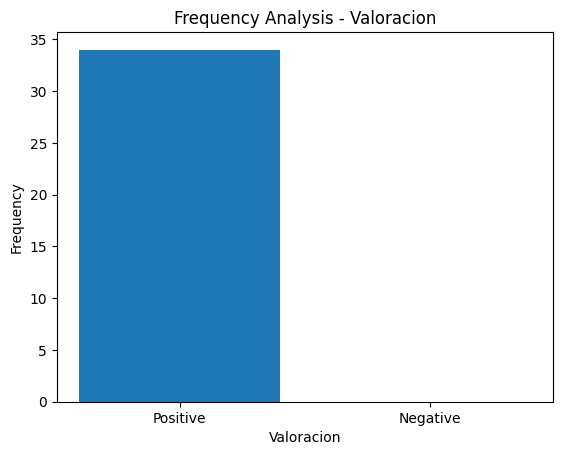

Valoracion Positive: 34 occurrences
Valoracion Negative: 0 occurrences


In [33]:
# Frequency analysis for "valoracion"
valoracion_counts = {'Positive': 0, 'Negative': 0}

# Count the occurrences of 'Positive' and 'Negative' in "predicted_sentiments"
for value in predicted_sentiments:
    if value == '1':
        valoracion_counts['Positive'] += 1
    elif value == '0':
        valoracion_counts['Negative'] += 1

# Plotting the graph
plt.bar(valoracion_counts.keys(), valoracion_counts.values())
plt.xlabel('Valoracion')
plt.ylabel('Frequency')
plt.title('Frequency Analysis - Valoracion')
plt.show()

# Frequency in text
for value, count in valoracion_counts.items():
    print(f"Valoracion {value}: {count} occurrences")

Con lo que confirmamos que el modelo, aunque no está sobreentrenado, tiende a predecir para la clase positiva. Cuando si observamos los valores reales:

In [34]:
print('Datos de entrenamiento:')
print(pd.Series(train_data2['ratings'].tolist()).value_counts(),'\n')
print('Datos de prueba:')
print(pd.Series(test_data2['ratings'].tolist()).value_counts())

Datos de entrenamiento:
1    164
0     27
dtype: int64 

Datos de prueba:
1    28
0     6
dtype: int64


Observamos que las clases aunque no balanceadas, no son en su totalidad 1.

## **Pregunta 6**

Ahora realiza el entrenamiento y evaluación de los conjuntos aumentados (reales más sintéticos). En este caso sí aplica un modelo con fine-tuning. ¿Por qué en este caso no se justificaría utilizar la técnica out-of-box para entrenar y evaluar directamente los datos con los comentarios sintéticos?


**R:** Los datos sintéticos se utilizan para entrenar con datos balanceados al modelo. Sin embargo, todos nuestros datos sintéticos parten del mismo texto de "Califique mal a este hotel porque". Por lo que es muy probable que el modelo out-of-box no se prediga bien teniendo en considerable parte de los datos, los datos sintéticos que son muy similares. Su accuracy va a disminuir si no se aplica fine-tuning. En un modelo de fine-tuning es que este proceso está diseñado para aprovechar y adaptar modelos de aprendizaje automático existentes, como modelos pre-entrenados, a tareas y conjuntos de datos específicos. El objetivo del fine-tuning es ajustar y especializar el modelo ya entrenado en una tarea específica, en lugar de introducir técnicas novedosas durante ese proceso.

El fine-tuning se basa en la transferencia de conocimiento aprendido previamente por un modelo pre-entrenado en una gran cantidad de datos. Esto se logra ajustando los pesos y parámetros del modelo pre-entrenado utilizando datos más específicos o de dominio objetivo. Al hacer esto, el modelo pre-entrenado se adapta a la tarea particular para la cual se está realizando el fine-tuning, mejorando su rendimiento y eficacia.

Introducir técnicas "out-of-the-box" durante el fine-tuning podría complicar el proceso y dificultar la transferencia de conocimientos. Además, las técnicas "out-of-the-box" suelen requerir configuraciones y ajustes específicos, y podrían no ser compatibles directamente con el modelo pre-entrenado o la tarea de fine-tuning en cuestión.

Aplicamos fine-tuning:

In [35]:
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
import tensorflow as tf

# Set batch size, learning rate, and number of epochs
batch_size = 16
learning_rate = 1e-5
num_epochs = 5

# Load the tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')
model2 = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-multilingual-cased', num_labels=2)

# Encode the text data
train_encodings = tokenizer(train_data1['comments'].tolist(), truncation=True, padding=True)
val_encodings = tokenizer(val_data1['comments'].tolist(), truncation=True, padding=True)
test_encodings = tokenizer(test_data1['comments'].tolist(), truncation=True, padding=True)

# Convert the labels to TensorFlow tensors
train_labels = tf.convert_to_tensor(train_data1['ratings'].tolist())
val_labels = tf.convert_to_tensor(val_data1['ratings'].tolist())
test_labels = tf.convert_to_tensor(test_data1['ratings'].tolist())

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), train_labels)).shuffle(len(train_data1['comments'])).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings), val_labels)).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), test_labels)).batch(batch_size)

# Fine-tune the model
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model2.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
model2.fit(train_dataset, validation_data=val_dataset, epochs=num_epochs)

# Evaluate the model on the test set
test_loss2, test_accuracy2 = model2.evaluate(test_dataset)
print(f"Test Loss: {test_loss2}, Test Accuracy: {test_accuracy2}")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/5
14/14 [==============================] - 36s 613ms/step - loss: 0.6561 - accuracy: 0.6188 - val_loss: 0.5973 - val_accuracy: 0.8125
Epoch 2/5
14/14 [==============================] - 6s 421ms/step - loss: 0.4983 - accuracy: 0.8834 - val_loss: 0.3947 - val_accuracy: 0.8542
Epoch 3/5
14/14 [==============================] - 6s 438ms/step - loss: 0.3115 - accuracy: 0.9148 - val_loss: 0.2940 - val_accuracy: 0.8542
Epoch 4/5
14/14 [==============================] - 6s 459ms/step - loss: 0.2165 - accuracy: 0.9148 - val_loss: 0.2505 - val_accuracy: 0.8750
Epoch 5/5
4/4 [==============================] - 2s 89ms/step - loss: 0.2735 - accuracy: 0.8980
Test Loss: 0.2735294699668884, Test Accuracy: 0.8979591727256775


Y observamos que en accuracy para validación obtuvimos un 89.80%, mientras que para prueba un 89.79%. Lo que nos dice que nuestro modelo no está sobreentrenado.

Generamos predicciones para ver distribución de clases, y confirmamos el accuracy en prueba:

In [36]:
# Predictions for test data
outputs_test = model2.predict(test_dataset)
predictions2_test = tf.argmax(outputs_test.logits, axis=1).numpy().tolist()

# Actual values from test data
actual_labels = test_labels.numpy().tolist()

# Compare predicted labels with actual labels
correct_predictions = sum(1 for pred, actual in zip(predictions2_test, actual_labels) if pred == actual)
total_predictions = len(actual_labels)

# Confirmation of test accuracy
accuracy = correct_predictions / total_predictions
print("Accuracy: {:.2%}".format(accuracy))

4/4 [==============================] - 3s 103ms/step
Accuracy: 89.80%


Observamos la distribución de clases:

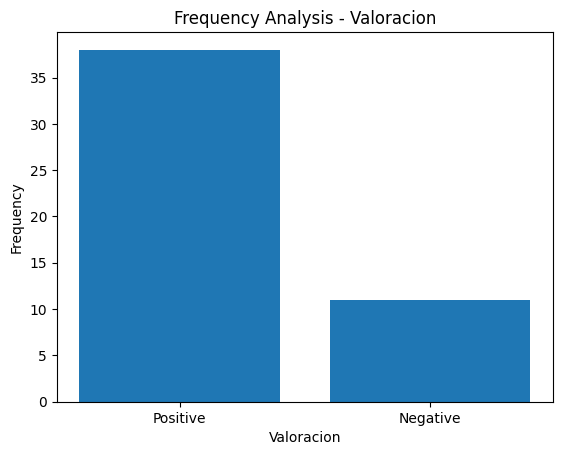

Valoracion Positive: 38 occurrences
Valoracion Negative: 11 occurrences


In [37]:
# Frequency analysis for "valoracion"
valoracion_counts = {'Positive': 0, 'Negative': 0}

# Count the occurrences of 'Positive' and 'Negative' in "predicted_sentiments"
for value in predictions2_test:
    if value == 1:
        valoracion_counts['Positive'] += 1
    elif value == 0:
        valoracion_counts['Negative'] += 1

# Plotting the graph
plt.bar(valoracion_counts.keys(), valoracion_counts.values())
plt.xlabel('Valoracion')
plt.ylabel('Frequency')
plt.title('Frequency Analysis - Valoracion')
plt.show()

# Frequency in text
for value, count in valoracion_counts.items():
    print(f"Valoracion {value}: {count} occurrences")

## **Pregunta 7**

Compara los resultados e incluye tus comentarios. En particular, indica si consideras que los comentarios sintéticos fueron de ayuda en este caso.

**R:** Se decidió aplicar el modelo 'distilbert-base-multilingual-cased' para la pregunta 5 y 6. En la 5 se aplicó el modelo sin fine-tuning y se obtuvo un accuracy de 83.25% en datos de entrenamiento, y 82.35% en prueba. Lo que nos dice que el modelo no está sobreentrenado. Sin embargo, al ver la distribución de clases de las predicciones, es claro que tiende a predecir hacia la clase positiva.


Aplicando los datos sintéticos y fine-tunning en la pregunta 6, se obtuvo un accuracy en validación del 89.80% y 89.79% en prueba. Lo que nos dice que el modelo no está sobreentrenado. Además, observando la distribución de clases para datos de prueba, se observan 36 valores de la clase positiva, y 13 de la negativa. Y si observamos la distribución real de clases de los datos de prueba:

In [38]:
pd.Series(test_labels.numpy().tolist()).value_counts()

1    33
0    16
dtype: int64

Podemos observar que, aunque no fue un accuracy del 100%, la distribución de clases sigue siendo similar. Lo cual nos dice que no tiende a predecir a la clase mayoritaria. Por lo que se concluye que aplicar comentarios sintéticos fueron de gran ayuda para balancear clases, y obtener un modelo con mejores resultados.

### **Conclusiones**

En conclusión, los nuevos modelos de lenguaje, como GPT, representan un avance significativo en la generación de texto automático. Estos modelos ofrecen una amplia gama de aplicaciones que pueden mejorar la eficiencia y la precisión en el procesamiento de lenguaje natural. Al utilizar herramientas como GPT dentro de nuestras prácticas, hemos presenciado un enriquecimiento notable en nuestro panorama general de los modelos de procesamiento de lenguaje natural.

Uno de los aspectos más destacados de GPT-2 es su capacidad para generar comentarios que se ajustan de manera impresionante al contexto que buscamos. Esta capacidad ad hoc ha demostrado ser beneficiosa para mejorar la precisión y los resultados finales de nuestro modelo. Al contar con una generación de texto más precisa y coherente, hemos obtenido un mayor nivel de exactitud en nuestras tareas de clasificación y procesamiento de texto.

Es fascinante cómo la combinación de diferentes técnicas, como el entrenamiento pre-entrenado y el fine-tuning, ha contribuido al desarrollo de modelos de IA más poderosos. Estas técnicas han permitido aprovechar el conocimiento y la experiencia previa del modelo pre-entrenado, y adaptarlo a tareas específicas para lograr resultados sobresalientes. El hecho de poder conjuntar todas estas técnicas demuestra el gran potencial que tienen los modelos de IA en la actualidad.

A medida que continuamos avanzando en el campo de la IA y los modelos de lenguaje, es emocionante pensar en las posibilidades futuras. Con el rápido progreso y la continua investigación en esta área, podemos esperar que los modelos de lenguaje evolucionen aún más, brindando aplicaciones aún más poderosas y precisas. Estamos presenciando un cambio significativo en cómo interactuamos con el lenguaje y cómo los sistemas automáticos pueden comprender y generar texto de manera cada vez más sofisticada.

En resumen, los modelos de clasificación basados en BERT, junto con otros modelos de lenguaje como GPT-2, están revolucionando la forma en que interactuamos con el procesamiento de lenguaje natural. Estos avances nos abren nuevas oportunidades en campos como la generación de texto automático, la traducción, la clasificación de texto y muchas otras aplicaciones. A medida que sigamos explorando y refinando estos modelos, podemos esperar que continúen sorprendiéndonos con su capacidad para comprender y generar lenguaje de manera cada vez más precisa y relevante.

## **Referencias:**

* Falcón Morales, L. E. (2023). Ejercicios Complementarios Web Scraping Tripadvisor semana 10 . Maestría en Inteligencia Artificial Aplicada. ITESM.
* Falcón Morales, L. E. (2023). Video 1/3 : Modelo Transformer BERT: [VIDEO]. Maestría en Inteligencia Artificial Aplicada. ITESM.

* Falcón Morales, L. E. (2023). Video 2/3 : Métricas y bases de datos en NLP: [VIDEO]. Maestría en Inteligencia Artificial Aplicada. ITESM.

* Falcón Morales, L. E. (2023). Video 3/3 : Ejemplos en JupyterNotebook: [VIDEO]. Maestría en Inteligencia Artificial Aplicada. ITESM.
* Gutiérrez, A., Armengol, J., Pàmies, M., Llop, J., Silveira, J., Pio, C., . . . Villegas, M. (2022). GPT2-base (gpt2-base-bne) trained with data from the National Library of Spain (BNE). Obtenido de Hugging Face: https://huggingface.co/PlanTL-GOB-ES/gpt2-base-bne

* OpenAI. (2019). Language Models are Unsupervised Multitask Learners [PDF]. Recuperado de https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf
* Pascual, F. (2022). Getting Started with Sentiment Analysis using Python. Retrieved from Hugging Face: https://huggingface.co/blog/sentiment-analysis-python
* Radford, A., Wu, J., Child, R., Luan, D., Amodei, D., & Sutskever, I. (2018). Improving Language Understanding by Generative Pre-training [PDF]. Recuperado de https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf
* Sanh, V., Debut, L., Chaumond, J., & Wolf, T. (2019). DistilBERT, a distilled version of BERT: smaller, faster, cheaper and lighter. Obtenido de Hugging Face: https://huggingface.co/distilbert-base-multilingual-cased

